In [48]:
using LinearAlgebra
using RDatasets
using GLM
using Pkg
using CSV
using DataFrames
using Plots
using Pkg
using RData
using Statistics 
using StatsBase
using Distributions
using Random
include("gam_impl.jl")

"Alternate code: \n# data = DataFrame(penalizedX, :auto)\n# data[!, :Z] = z\n\n# term = @formula(term(:Z) ~ sum(term.(0 + Symbol.(names(data, Not(:Z))))), data)\n\n# terms = term.((Symbol.(names(data, Not(:Z)))))\n# push!(terms, 0)\n# linear_model = lm(term(:Z) ~ sum(term.(0 + Symbol.(names(data, Not(:Z))))), data)\n# b = GLM.coef(linear_model)\n# trA = sum(influence(linear_model).hat[1:n])\n\n# norm = sum((z- predict(linear_model))[1:n].^2)\n\n\n"

# Generalized Additive Models

### Introduction

Generalized Additive Models use additional functional bases to allow for more complex relationships between independent and dependent variables. In particular, they permit fits of the form: 

$$g(y) = f_1 + f_2(X_1) + f_3(X_2) + \cdots f_k(X_k) + \epsilon_i, $$

where each $f$ is a smooth function, $\epsilon \sim \text{Exponential Family}$, and $g$ is a standard link function from Generalized Additive Models. If $f_i$ was linear, this would reproduce linear regression $\beta_1 x_1 + \cdots \beta_n x_n$.

The key idea to make Generalized Additive Models tractable is that we can represent function each function as follows:
$$f_i = \beta_1 g_1 + \beta_2 g_2 + ... \beta_d g_d$$


where $\beta_i$ is a real number and $g_i$ is some pre-constructed basis function. We will generally cubic regression splines, which are degree-3 polynomials merge together at so-called knot points, such that derivates exist and are continuous. This becomes just another basis, just like polynomial regression, which can be fit either with Least Squares or Maximum Likelihood Estimation.

### Generalized Additive Models as Penalized Generalized Linear Models

Using the ideas above, we will show GAMs can be understand and fit as penalized GLM models. 

The P-IRLS iteration has form: 

$$\beta^{k+1} = \text{argmin}_{\beta^{k+1}} \Vert \sqrt{W^{k}}(X \beta^{k} - z^{k}) \rVert + \sum_{i = 1}^{m} \lambda_i (\beta^{k})^{T} S_i \beta^{k}$$

Note that each iteration this is a penalized, weighted linear least squares problem with weights $\sqrt{W^{k}}$. Even with the addition of a penalization term, we can use tools from Numerical Linear Algebra to efficiently solve this. As a result, each iteration produces a quadratic approximation of the Log Likelihood. 

In our iteration, $W_{ii} = G^{k}_{ii} [V(\mu_i^{k})]^{-1}$, $V(\mu_i) \phi = \text{Var}(Y_i)$. $z_k$ is the pseudo-data, defined to be $z^{k} = X \beta^{k} + G^{k}(y - \mu^{k})$, and $G^{k}_{ii} = g'(\mu_i^{k})$

### Civil War Example

In [62]:
df = load("../civil_wars.RData", convert=true)["x"];
df = dropmissing(df);

In [3]:

# We use the Gamma distribution despite deaths being discrete due to very large counts

# 25th percentile battle deaths
quantile(df[:, "battledeadbest"], 0.25)

# Median battle deaths
quantile(df[:, "battledeadbest"], 0.50)

maximum(df[:, "battledeadbest"])


y = df[:, "battledeadbest"] / 100000
X = Matrix(df[:, filter(x -> x ∈ ["relfrac", "gdpsq", "duration", "pop"], names(df))]);

n, p = size(X)

for i in 1:p
    X[:, i] = (X[:, i] .- minimum(X[:,i])) ./ (maximum(X[:, i]) - minimum(X[:, i]));
end


# sp_list = [0.01; 0.01; 0.01];
sp_list = [0.01; 0.01; 0.01; 0.01];


# sp_list = [0.00;0.00; 0.00; 0.00; 0.00];

knot_locs, augX, S_list = construct_augmented(X, nothing, 15);
gam_coeffs, betaCI_bottom, betaCI_top = fitGAM(y, augX, S_list, sp_list);

In [4]:
pred_points = collect((1:100) / 100)

f1 = repeat([quantile(X[:, 1], 0.50)], length(pred_points))
f2 = repeat([quantile(X[:, 2], 0.50)], length(pred_points))
f3 = repeat([quantile(X[:, 3], 0.50)], length(pred_points))
f4 = repeat([quantile(X[:, 4], 0.50)], length(pred_points))

war_len_X = [pred_points f2 f3 f4]

 _, war_len_augX, _ = construct_augmented(war_len_X, knot_locs);
 warlen_results = exp.(war_len_augX * gam_coeffs) .* 100000;

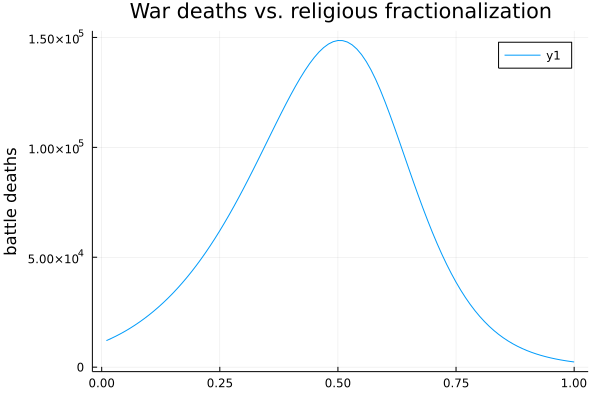

In [30]:
plot_ref = plot(pred_points, warlen_results, title="War deaths vs. religious fractionalization", ylabel="battle deaths")
savefig(plot_ref, "../Visualizations/civil_wars/deaths_vs_relfrac.pdf")
plot_ref

In [23]:
feature2 = [f1 pred_points f3 f4]

 _, feature2_augX, _ = construct_augmented(feature2, knot_locs);
 feature2_results = exp.(feature2_augX * gam_coeffs) .* 100000;

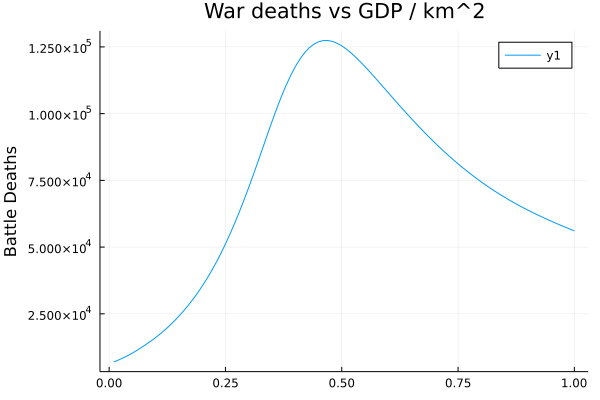

In [33]:
plot_ref = plot(pred_points, feature2_results, title="War deaths vs GDP / km^2", ylabel="Battle Deaths")
savefig(plot_ref, "../Visualizations/civil_wars/deaths_vs_gdp.pdf")
plot_ref

In [25]:
feature3 = [f1 f2 pred_points f4]

 _, feature3_augX, _ = construct_augmented(feature3, knot_locs);
 feature3_results = exp.(feature3_augX * gam_coeffs) .* 100000;

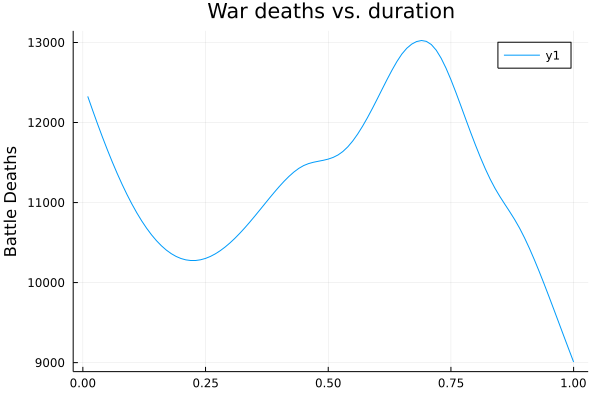

In [26]:
plot_ref = plot(pred_points, feature3_results, title="War deaths vs. duration", ylabel="Battle Deaths")
savefig(plot_ref, "../Visualizations/civil_wars/deaths_vs_duration.pdf")
plot_ref

In [27]:
feature4 = [f1 f2 f3 pred_points]

 _, feature4_augX, _ = construct_augmented(feature4, knot_locs);
 feature4_results = exp.(feature4_augX * gam_coeffs) .* 100000;

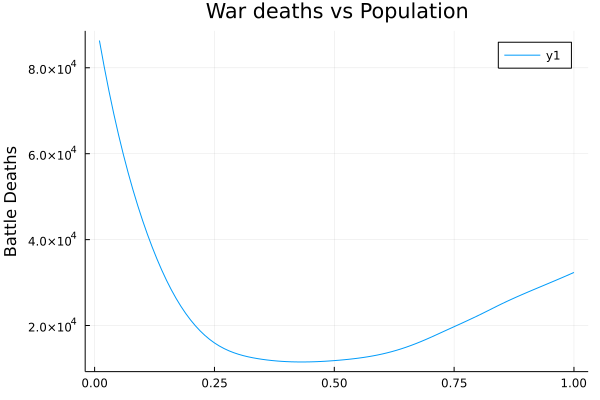

In [29]:
plot_ref = plot(pred_points, feature4_results, title="War deaths vs Population", ylabel="Battle Deaths")
savefig(plot_ref, "../Visualizations/civil_wars/deaths_vs_pop.pdf")
plot_ref

### Deriving Bayesian Credible Intervals for Generative Additive Models

We begin by defining the credible intervals for Additive Models, then perform the generalization. We generally believe that the true function modeling the data generating process will be smooth. Following Wood, 2006, we can formalize this intuition with a Bayesian improper prior, defined as follows: 

$$f_{\beta}(\beta) \propto e^{-\frac{1}{2} \beta^{\top}\left(\sum \frac{S_i}{\tau_{i}}\right) \beta}$$

Essentially, the prior assumes that each components of wiggliness, $\beta^{T}S_i \beta$ is independent and exponentially distributed with expected value $\tau_i$. 

Note that in the derivation, we first will define the sampling behavior of $\beta$ for additive models, then extend it to Generalized Additive Models. 

In Bayesian Linear Regression, we show the pdf of f is constructed as follows: 

$$f(y \mid \beta) \propto \exp \left[\frac{-\frac{1}{2}(y-x \beta)^{\top} W (y-x \beta)}{\sigma^{2}}\right]$$


Using Bayes' Rule:
$$
\begin{aligned}
f(\beta \mid y) & \propto f(y \mid \beta) f(\beta) \\
& \propto \exp \left(\frac{-\frac{1}{2}(y-x \beta)^{\top} W(y-x \beta)}{\sigma^{2}}-\frac{1}{2} \beta^{\top}\left(\Sigma \frac{S_{i}}{\tau_{i}}\right) \beta\right.\\
& \propto \exp \left(-\frac{1}{2}\left[\frac{y^{\top} Wy}{\sigma^{2}}-\frac{2 \beta^{\top} x^{\top} W y}{\sigma^{2}}+\beta^{\top}\left(\frac{x^{\top} x}{\sigma^{2}}-\sum \frac{s_{i}}{\tau_{i}}\right) \beta\right]\right. \\
& \propto \exp \left(-\frac{1}{2}\left[\frac{-2 \beta^{\top} x^{\top} W y}{\sigma^{2}}+\beta^{\top}\left(\frac{x^{\top} x}{\sigma^{2}}-\sum \frac{S_{i}}{\tau_{i}}\right) \beta\right]\right)
\end{aligned}
$$
where we drop $\frac{y^{\top} W y}{\sigma^{2}}$ into the denominator and out of the proportion.


Recall pdf of multivariate normal: 
$$
\begin{aligned}
f_{x}(\vec{x})&=\frac{\exp (-\frac{1}{2}(x-\mu)^{\top} \Sigma^{-1}(x-\mu) \mid}{\sqrt{(2 \pi)^{k}} \sqrt{|\Sigma|}} \\ 
& \propto \exp (-\frac{1}{2}(x-\mu)^{\top} \Sigma^{-1}(x-\mu)).
\end{aligned}
$$


Let $\left.\alpha \sim \mathcal{N}\left(\left[x^{\top} W x+\Sigma \lambda_{i} S_{i}\right]^{-1} X^{T} W y,\left[x^{\top} W x+\sum \lambda_{i} S_{i}\right)\right]^{-1} \sigma^{2}\right)$

The pdf of $\alpha$ is proportional as follows:
$$
\begin{aligned}
f_{\alpha}(\alpha) & \propto \exp ( -\frac{1}{2}(a-[x^{\top} W x+\sum \lambda_{i} S_{i})]^{-1} X^{\top} W y)^{T} ) ( X^T W X + \Sigma \lambda_i S_i)  ( a - [X^{T} W X + \Sigma \lambda_i S_i]^{-1} X^{T} W Y / \sigma^2). \\ 
&\propto \exp (-\frac{1}{2} (-2 \alpha^{T} X^{T} W y / \sigma^{2} + \alpha^{T} (X^{T} W X / \sigma^{2} + \Sigma\lambda_i S_i / \sigma^{2}) \alpha ) \\ 
\end{aligned}
$$


We can now compare $f_\alpha(a)$ and $f(\beta | y)$, and choose $\tau_i = \frac{\sigma^2}{\lambda_i}$

We get: 
$$\begin{aligned}
\beta | y &\sim \mathcal{N} ( X^{T} W X + \Sigma \lambda_i S_i )^{-1} X^{T} W Y, [X^{T} W X + \Sigma \lambda_i S_i]^{-1} \sigma^{2}) \\
\beta |  y &\sim \mathcal{N}(\hat{\beta}, (W^{T}WX + \Sigma \lambda_i S_i)^{-1} \sigma^{2}) \\
\end{aligned}
$$


## Bayesian Credible Intervals for Generalized Additive Models 

Given augmented data matrix $X$, we have 

$$g(\mu_i) = X_i \beta, \mu_i = E(Y_i), \quad Y_i \sim \text{exponential family}$$

We estimate $\beta$ via the minimization of $-l(\beta) + \frac{1}{2}\sum_{i=1}^{m} \lambda_i \beta^{T} S \beta$, where $l$ is the log likelihood. 

The P-IRLS algorithm produces the following iteration: 

$$z_k = X \beta_k + G(y - \mu_k)$$

where $G = \textrm{diag}(g'(\mu_i))$, and $W$ is weight matrix as defined in IRLS.

Now, by the Lindeberg-Feller CLT,
$$v := X^T W z \rightarrow \mathcal{N}(X^T W X \beta, X^T W X \phi)$$
        
The Lindeberg-Feller CLT requires certain assumptions in order to be invoked, and in our case, a sufficient condition is 

$$\frac{(X_{ij} W_i^{1/2})^2}{\sum_{i}[(X_{ij} W_i^{1/2})^2]^2} \rightarrow 0 \hspace{1mm} \forall i,j$$  


which may be interpreted as no feature of any data point being 'too' important or large in comparison with other data points. 

We briefly explain the frequentist approach to obtaining C.I.s for GAMs in order to set the stage of comparion and motivation for using a Bayesian framework. Recall $\hat{\beta} = (X^T W X + \sum_i \lambda_i S_i)^{-1} v$, so by the asymptotic normality of $X^T W y$,

$$\hat{\beta} \rightarrow \mathcal{N}(\mathbb{E}[\hat{\beta}], V_f)$$
            
where $V_f = (X^T W X + \sum_i \lambda_i S_i)^{-1} X^T W X (X^T W X + \sum_i \lambda_i S_i)^{-1} \phi$. In general, $\hat{\beta}$ is biased. This makes sense since we our choice of $\lambda$, whether it be through validation or other more sophisticated methods, can not exceed the prescribed rank, and thus degree, $q$ of the basis used to construct the underlying smooth functions. In general, the true functions are infinite dimensional (w.r.t. any polynomial basis on its domain) so that no matter how much data we obtain, we will never be able to recover the true function exactly.

In this light, we now consider the Bayesian framework with the following prior attached to $\beta$. The philosophical reasoning behind this choice was discussed above.
        
for prior, $$\beta \propto \exp \{ -\frac{1}{2} \beta^T (\sum_i \lambda_i S_i) \beta \}$$, the posterior is given as, through a similar derivation as the additive model case:


$$\beta | v ~ \mathcal{N}(\hat{\beta},(X^T W X+ \sum_i \lambda_i S_i)^{-1} \phi)$$ 


The reason for the asymptotic non-biasedness of this method hinges on the fact we _assumed_ that the function (or equivalently, $\beta$) were distributed according to some prior distribution with a fixed dimension $q$ (as seen by the dimension of smoothing matrix $S_i \in \mathbb{R}^{q_i \times q_i} \hspace{1mm} \forall i=1,..,p$.

Since the data $X$ is often standarized in practice so that smoothing splines on a fixed interval, say $[0,1]$, may be fit, the covariance matrix is extremely sensitive to the specification of the the $\lambda_i$. Thus, more conventional methods like grid-search via ordinary validation and generalized cross validation (GCV) may not suffice. Alternatives include iteratively minimizing the GCV or its equivalent counterpart, the unbiased risk estimator (UBRE) or a scaled version of the AIC, through a Quasi-Newton method (see Wood 2006).

To compute this, use the estimates of $v, W$ achieved at the convergence of P-IRLS. Generally, for exponential distributions, $\phi$ is known, but if not, we can estimate $\hat{\phi} = \Vert W^{1/2}(y - \hat{\mu})\rVert^{2} / \text{tr}(I - A)$